# 特徴選択アルゴリズム

正則化されていないモデルに使われてる

特徴選択　→　元の特徴量の一部を選択する。 <br>

前向き法：有用な特徴量を一つずつ選択していく　<br>
後ろ向き法：不要な特徴量を一つずつ削除していく <br>

ここでは、後ろ向き法：逐次交代選択と呼ばれ、Sequential Backward Selection, SBS を使用

もともとの、「特徴空間の次元を減らす」ことにあり、分類器の性能の低下を最小限に抑えた上で計算効率を改善する。

原理：新しい特徴部分空間に目的の個数の特徴量が含まれるまで、特徴量全体から特徴量を逐次的に削除していく。

SBSアルゴリズムはまだ実装されていないため、一から実装する。

In [21]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

### ワインの特徴量について考える

In [22]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### データをトレーニングデータとテストデータに分割

In [25]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

### データのスケーリング(データの標準化)

In [26]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### KNN分類器のインスタンス生成

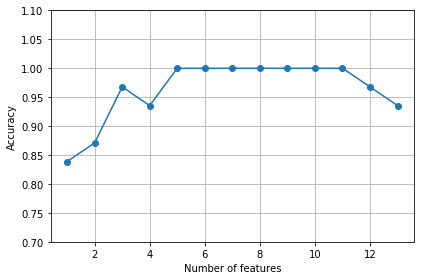

In [27]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# 近傍点数が2点
knn = KNeighborsClassifier(n_neighbors=2)

# 逐次後退選択のインスタンスを生成　特徴量の個数が1になるまで特徴量を選択
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# 近傍点の個数のリスト
# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

k = 5,6,7,8,9,10,11 に対して、分類器が100％の正解率を達成した。 <br>
それぞれの特徴量を表示

In [28]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


13個すべての特徴量を用いてモデルに適合

In [30]:
knn.fit(X_train_std, y_train)

# トレーニングの正解率
print('Training accuracy:', knn.score(X_train_std, y_train))
# テストの正解率
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.944444444444


テストの正解率が94％で少し、過学習に陥ってる。　<br>
そこで、成績のよかった5つの特徴量だけで分類すると、

In [31]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.959677419355
Test accuracy: 0.962962962963


トレーニングとテストの正解率に差がなくなり、過学習がおさえられていることがわかる。

<br>
<br>
上記にかいたのは、L1正則化のロジスティック回帰を使って無駄な特徴量を取り除き、SBSアルゴリズムで特徴量を選択してきた。<br>
<br>
データセットから重要な特徴量を簡単に選択する方法で、ランダムフォレストがある。


# ランダムフォレスト

データが線形分離かどうかはおいといて、フォレスト内の決定木から計算されて、重要な特徴量を測定できる。　<br>
scikit-learnで実装できる

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


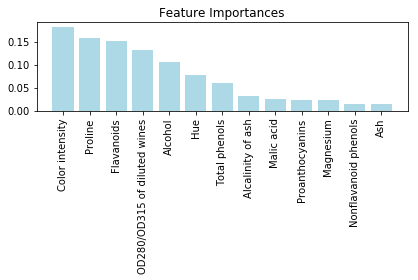

In [33]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

# ランダムyフォレストオブジェクトの生成
# 木の個数＝10,000
forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)
# モデルに適合
forest.fit(X_train, y_train)

# 特徴量の重要度を抽出
importances = forest.feature_importances_

# 重要度の降順で特徴量のインデックスを取得
indices = np.argsort(importances)[::-1]

# 重要度の降順で特徴量の名称＋重要度の表示
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

#### このクラスを分類するのに、最も適した特徴量は、ワインの色の強さであることがわかる

重要度が0.15以上のものを抽出

In [36]:
X_selected = forest.transform(X_train,threshold=0.15)

X_selected.shape

C:\Users\logma\python\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


(124, 3)